In [1]:
import datetime
import itertools
import json
import os
import time

import alphashape
import argparse
import cv2
import hdbscan
import igraph as ig

from collections import namedtuple, defaultdict
from matplotlib.path import Path
import matplotlib.pyplot as plt
import metis
import networkx as nx
import numpy as np
import scipy


import pickle
import warnings

from concavehull import concavehull
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches
from matplotlib.widgets import CheckButtons, Button, Slider, LassoSelector, RadioButtons, TextBox, RectangleSelector
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from skimage import filters
from sklearn.ensemble import RandomForestClassifier

from hulls import ConcaveHull

import geometry, segmentation as seg, grapher, edge_detection


warnings.simplefilter("ignore")


In [2]:
img_id = 0
NX = NY = 501
with open(f'segmentation/edges/{str(img_id).zfill(3)}.json') as f:
    edges = json.load(f)
img = plt.imread(f'unsegmented/{str(img_id).zfill(3)}.tif')

In [3]:
img_meijer = filters.meijering(img)

In [4]:
points_arr = np.zeros((NX * NY, 2), dtype=np.int32)
for ix in range(NX):
    for iy in range(NY):
        idx = edge_detection.coord2idx(ix, iy, NY=NY)
        points_arr[idx, :] = (ix, iy)

172.84745762711864 11.718471703533467 59
224.17142857142858 25.619591836734696 35
169.6875 42.421875 16
44.292957746478876 0.4990755802420155 355
184.69444444444446 20.521604938271604 36
311.60526315789474 16.400277008310248 76
102.58841463414635 656
27.51685393258427 1.2367125362959221 89
178.14285714285714 101.79591836734694 7
78.0625 19.515625 16
269.4166666666667 89.80555555555556 12
226.54545454545453 82.3801652892562 11
282.0 80.57142857142857 14
52.827586206896555 7.2865636147443515 29
97.02926829268293 1.893254015466984 205


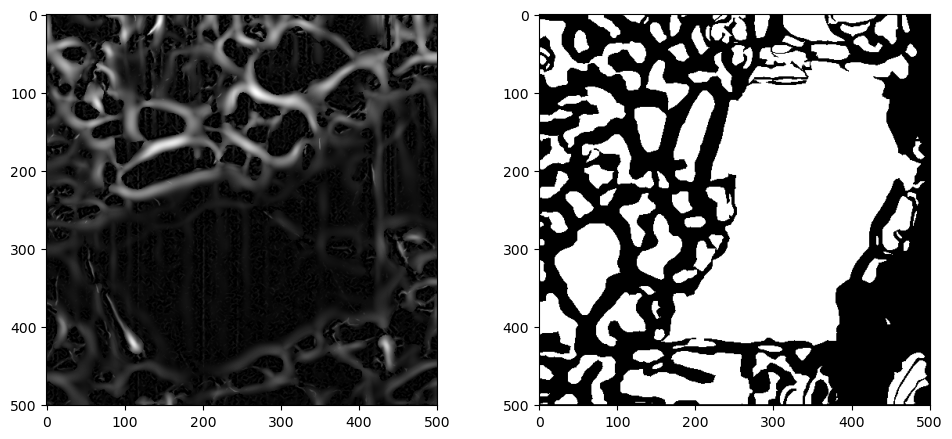

In [5]:
img_res = np.zeros(img.shape)
for level in ['0', '1', '2']:
    level_edges = edges[level]
    for point_set in level_edges:
        polygon = []
        for idx in point_set:
            x, y = edge_detection.idx2coord(idx)
            polygon.append((x, y))
        inside_points = edge_detection.points_inside_polygon(polygon, points_arr)
        if inside_points.shape[0] == 0:
            continue
        if inside_points.shape[0] == 1:
            img_res[inside_points[0, 0], inside_points[0, 1]] = 1
        else:
            arr = np.asarray(inside_points)
            if arr.shape[0] > 1000 and level == '0':
                continue
            if level == '1' and arr.shape[0] > 68000:
                continue
            aspect = arr.shape[0] / len(polygon)
            aspect2 = 4 * arr.shape[0] / len(polygon) ** 2
            if aspect > 40 and len(polygon) < 500:
                print(aspect, aspect2, len(polygon))
                continue
            elif 27 < aspect < 28:
                print(aspect, aspect2, len(polygon))
                continue
            else:
                if 100 < aspect < 110:
                    print(aspect, len(polygon))
                img_res[(arr[:, 0], arr[:, 1])] = 1

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_meijer, cmap='gray');
ax[1].imshow(img_res, cmap='gray');

plt.tight_layout();

In [6]:
print(1 - np.average(img_res))

0.4535559619284385
